In [16]:
import polars as pl
import polars_ds as pds
import itables
import plotnine as p9

In [17]:
df = (
    pl.scan_parquet("results.parquet")
    .with_columns(
        pl.when(pl.col("parameters").str.starts_with('{"n'))
        .then(pds.extract_numbers("parameters").list.get(0).cast(pl.UInt32))
        .alias("size")
    )
    .collect()
)

recent = df.filter(
    pl.col("timestamp").eq(pl.col("timestamp").max().over("function", "parameters"))
)

In [18]:
def compare_over_sizes(df: pl.DataFrame):
    return (
        p9.ggplot(
            df,
            p9.aes(x="size", y="mean", group="function", color="function"),
        )
        + p9.geom_point()
        + p9.geom_line()
        + p9.geom_errorbar(p9.aes(ymin="min", ymax="max"))
        + p9.theme_538()
    )

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


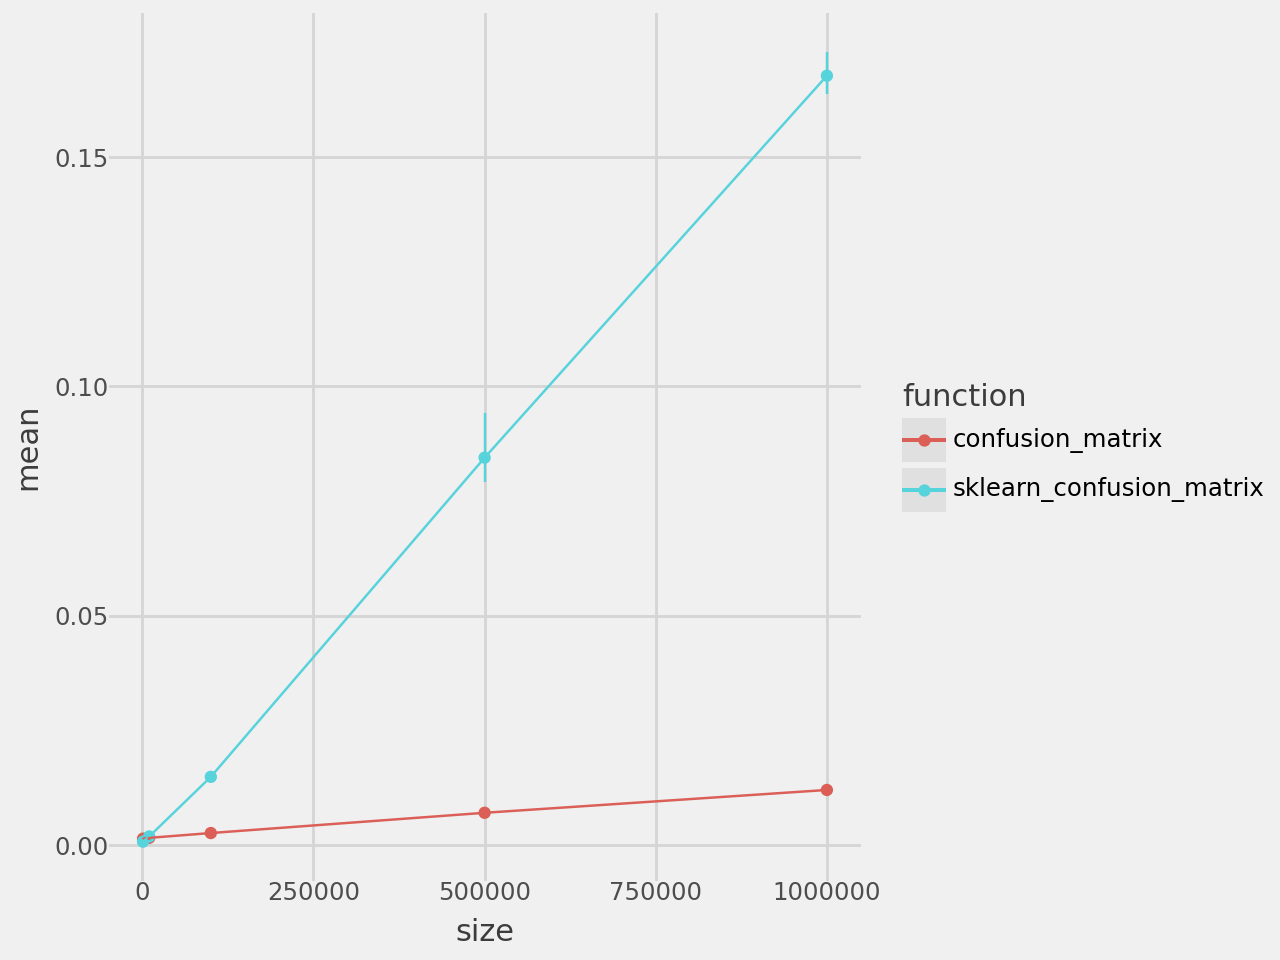

In [11]:
(
    recent.filter(
        pl.col("function").str.ends_with("confusion_matrix"),
        pl.col("size").gt(100),
    ).pipe(compare_over_sizes)
)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


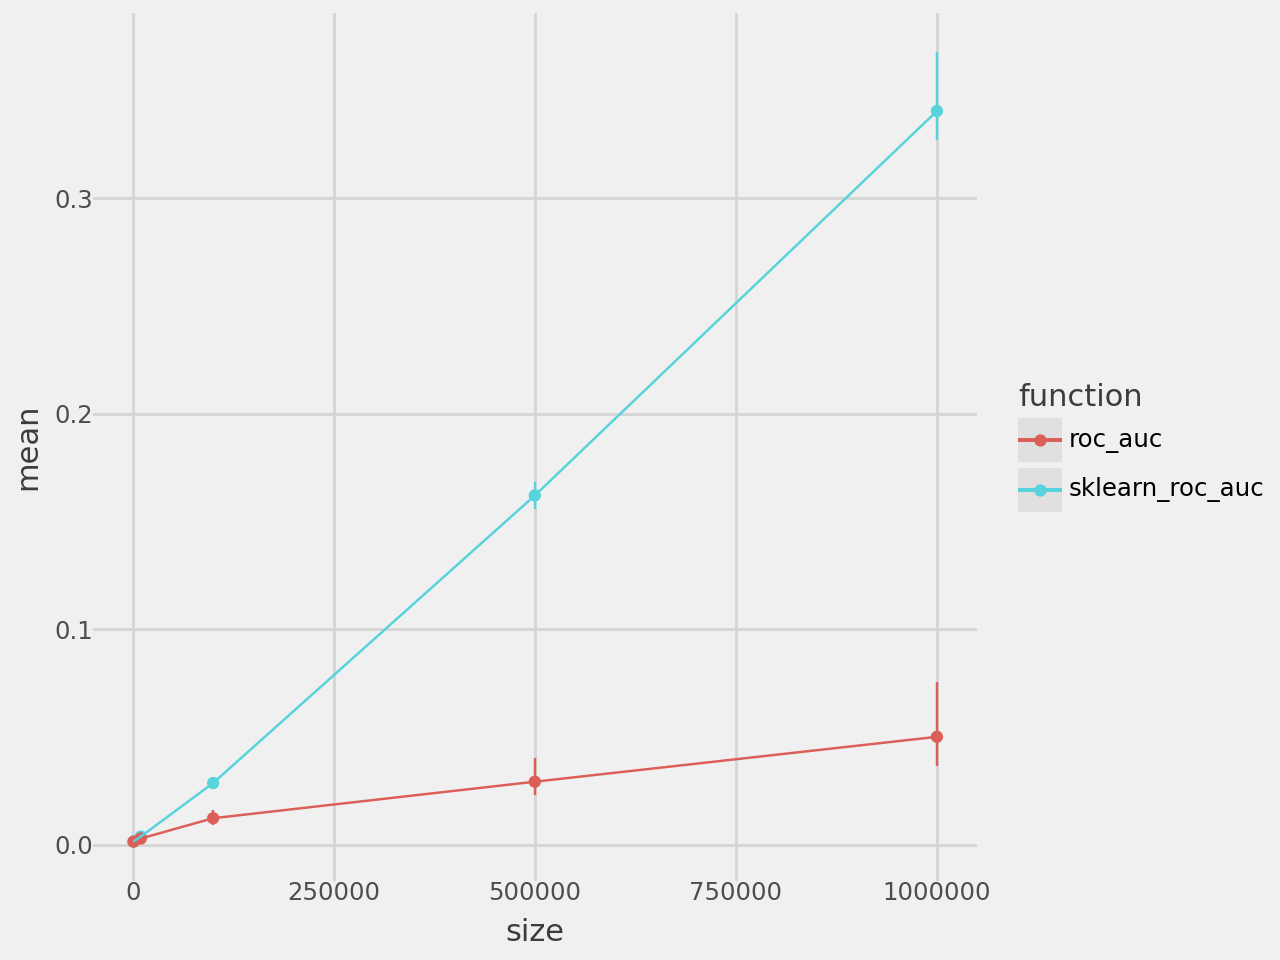

In [12]:
(
    recent.filter(
        pl.col("function").str.ends_with("roc_auc"),
        pl.col("size").gt(100),
    ).pipe(compare_over_sizes)
)

In [26]:
correlation_matrix = (
    recent.filter(pl.col("function").str.ends_with("correlation_matrix"))
    .with_columns(pl.col("parameters").str.json_decode())
    .unnest("parameters")
    .filter(pl.col("n_cols").eq(100))
    .drop("size")
    .rename({"n_rows": "size"})
)

In [ ]:
correlation_matrix.pipe(compare_over_sizes)